# Demonstration of distribution reweighting

**hep_ml.reweight** contains methods to reweight distributions. 
Typically we use reweighting of monte-carlo to fight drawbacks of simulation, though there are many applications.

In this example we reweight multidimensional distibutions: `original` and `target`, the aim is to find new weights for original distribution, such that these multidimensional distributions will coincide. 

These is a __toy example__ without real physical meaning.

Pay attention: equality of distibutions for each feature $\neq$ equality of multivariate dist

In [1]:
%pylab inline
figsize(16, 8)

import root_numpy
import pandas
from hep_ml import reweight

Populating the interactive namespace from numpy and matplotlib


/Users/axelr/ipython/hep_ml/hep_ml/reweight.py:49: UserWarning: Module hep_ml.reweight is unstable, it's API may be changed in near future.
  warn("Module hep_ml.reweight is unstable, it's API may be changed in near future.")


### Downloading data

In [2]:
storage = 'https://github.com/arogozhnikov/hep_ml/blob/data/data_to_download/'
!wget -O ../data/MC_distribution.root -nc $storage/MC_distribution.root?raw=true
!wget -O ../data/RD_distribution.root -nc $storage/RD_distribution.root?raw=true

Файл «../data/MC_distribution.root» уже существует; не загружается.
Файл «../data/RD_distribution.root» уже существует; не загружается.


In [3]:
columns = ['hSPD', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum']

original = root_numpy.root2array('../data/MC_distribution.root', branches=columns)
target = root_numpy.root2array('../data/RD_distribution.root', branches=columns)

original = pandas.DataFrame(original)
target = pandas.DataFrame(target)

original_weights = numpy.ones(len(original))

In [4]:
from hep_ml.metrics_utils import ks_2samp_weighted
hist_settings = {'bins': 100, 'normed': True, 'alpha': 0.7}

def draw_distributions(new_original_weights):
    for id, column in enumerate(columns, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99])
        subplot(2, 3, id)
        hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        hist(target[column], range=xlim, **hist_settings)
        title(column)
        print 'KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=numpy.ones(len(target), dtype=float))        

## Original distributions
KS = Kolmogorov-Smirnov distance

In [5]:
# pay attention, actually we have very few data
len(original), len(target)

(1000000, 21441)

KS over  hSPD  =  0.520354072828
KS over  pt_b  =  0.2163936444
KS over  pt_phi  =  0.402011359241
KS over  vchi2_b  =  0.404663850873
KS over  mu_pt_sum  =  0.2163936444


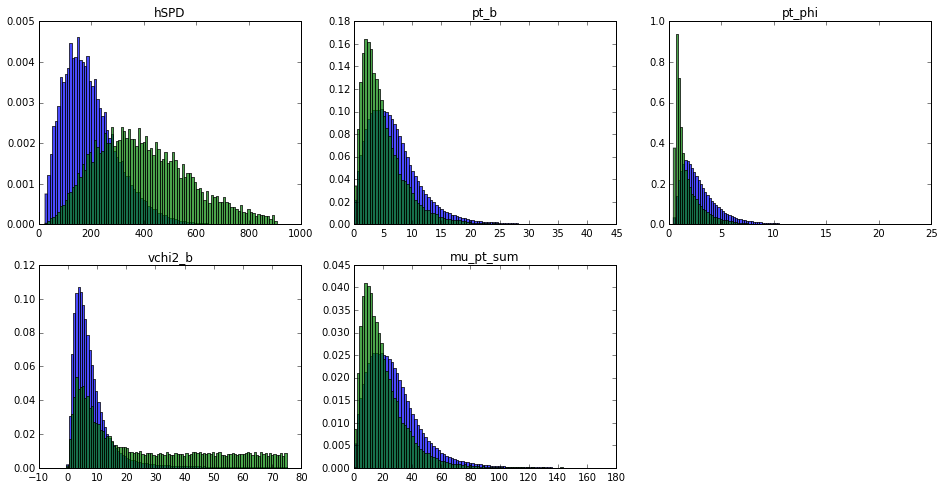

In [6]:
draw_distributions(original_weights)

# Bins-based reweighting in n dimensions
Typical way to reweight distributions is based on bins.

KS over  hSPD  =  0.274734612735
KS over  pt_b  =  0.0857468155148
KS over  pt_phi  =  0.138008759677
KS over  vchi2_b  =  0.236350400012
KS over  mu_pt_sum  =  0.0857468155148


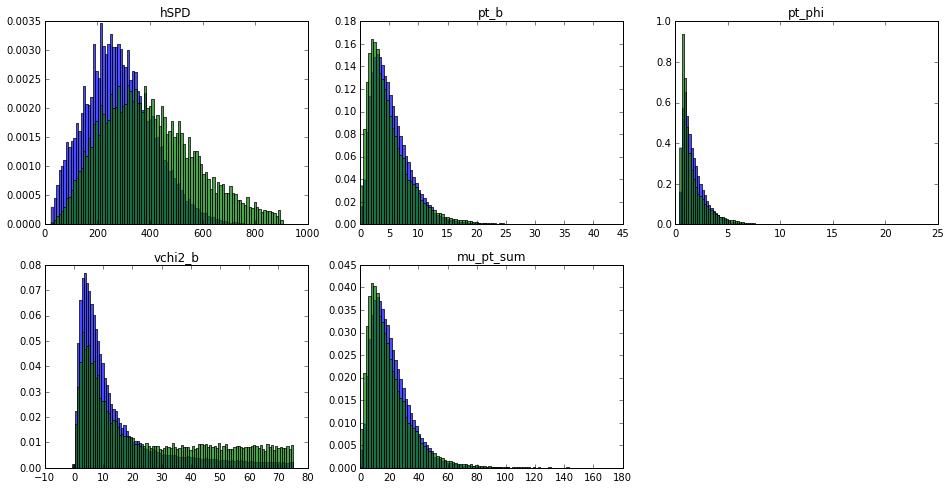

In [7]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original, target)

bins_weights = bins_reweighter.predict_weights(original)
draw_distributions(bins_weights)

# Gradient Boosted Reweighter

This algorithm is inspired by gradient boosting and is able to fight curse of dimensionality.
It uses decision trees and special loss functiion (**ReweightLossFunction**).

**GBReweighter** supports negative weights (to reweight MC to splotted real data).

KS over  hSPD  =  0.0290814354862
KS over  pt_b  =  0.0239683012464
KS over  pt_phi  =  0.0251119333667
KS over  vchi2_b  =  0.0261620060653
KS over  mu_pt_sum  =  0.0239683012464


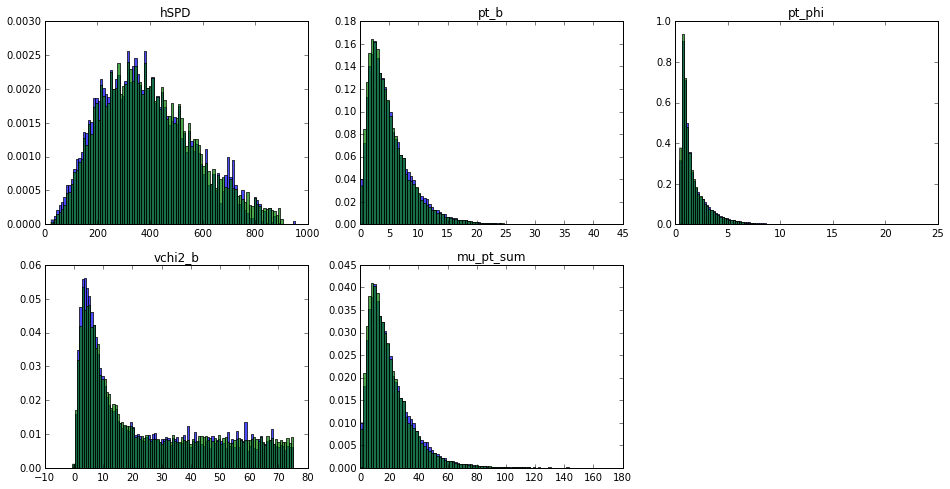

In [8]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                   gb_args={'subsample': 0.6})
reweighter.fit(original, target)

gb_weights = reweighter.predict_weights(original)
draw_distributions(gb_weights)

## Comparing some simple expressions:
the most interesting is checking some other variables in multidimensional distributions (those are expressed via original variables).

In [9]:
def check_ks_of_expression(expression):
    col_original = original.eval(expression, engine='python')
    col_target = target.eval(expression, engine='python')
    w_target = numpy.ones(len(col_target), dtype='float')
    print 'No reweight   KS:', ks_2samp_weighted(col_original, col_target, weights1=original_weights, weights2=w_target)        
    print 'Bins reweight KS:', ks_2samp_weighted(col_original, col_target, weights1=bins_weights, weights2=w_target)
    print 'GB Reweight   KS:', ks_2samp_weighted(col_original, col_target, weights1=gb_weights, weights2=w_target)

In [10]:
check_ks_of_expression('hSPD')

No reweight   KS: 0.520354072828
Bins reweight KS: 0.274734612735
GB Reweight   KS: 0.0290814354862


In [11]:
check_ks_of_expression('hSPD * pt_phi')

No reweight   KS: 0.0893469908354
Bins reweight KS: 0.126334359888
GB Reweight   KS: 0.0128045112737


In [12]:
check_ks_of_expression('hSPD * pt_phi * vchi2_b')

No reweight   KS: 0.369074009072
Bins reweight KS: 0.257688788148
GB Reweight   KS: 0.0248108553065


In [13]:
check_ks_of_expression('pt_b * pt_phi / hSPD ')

No reweight   KS: 0.478065348794
Bins reweight KS: 0.268682176566
GB Reweight   KS: 0.0457731011338


In [14]:
check_ks_of_expression('hSPD * pt_b * vchi2_b / pt_phi')

No reweight   KS: 0.49379287783
Bins reweight KS: 0.271852132719
GB Reweight   KS: 0.0272991144248


# GB-discrimination
let's check how well the classifier is able to distinguish these distributions. ROC AUC is taken as measure of quality.

For this puprose we split data into train and test, then train a classifier do distinguish these distributions.
If ROC AUC = 0.5 on test, distibutions are equal, if ROC AUC = 1.0, they are ideally separable.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

data = numpy.concatenate([original, target])
labels = numpy.array([0] * len(original) + [1] * len(target))

weights = {}
weights['original'] = original_weights
weights['bins'] = bins_weights
weights['gb_weights'] = gb_weights


for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts)

original 0.887911686883
bins 0.783422628614
gb_weights 0.526811149651
